<a href="https://colab.research.google.com/github/datasith/ML-Notebooks-TensorFlow/blob/main/Image_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using CNNs (AlexNet)

In this notebook I provide a short introduction and overview of the process involved in building a **Convolutional Neural Network** (CNN) in **TensorFlow** using the **AlexNet** network architecture.

The model will help us with the task of **Binary Image Classification** using images of hot dogs and not hot dogs. 🌭

---
**Author:** Cisco Zabala ([@datasith](https://twitter.com/datasith) | [LinkedIn](https://www.linkedin.com/in/datasith/) | [Kaggle](https://kaggle.com/thedatasith) | [GitHub](https://github.com/datasith))

## Background

Before talking about the **AlexNet** network, we first need to mention the **ImageNet** dataset and its associated **ImageNet Large-Scale Visual Recognition Challenge (ILSVRC)**. The [**ImageNet project**](https://www.image-net.org/) comprises a database with over 14 million annotated images (objects and even bounding boxes for a percentage of them). The objects span over 20,000 categories. In 2010, the project launched the **ILSVRC** challenge, and in 2012 **AlexNet** won the with a top-5 error rate of 15.3%, surpassing the previous year winning error rate by more than 12%.

![](https://raw.github.com/datasith/ML-Notebooks-TensorFlow/main/img//Image_Classification_AlexNet/imagenet_banner.jpeg)

The AlexNet model combines **Convolution** layers with **MaxPooling** ones—as is know commonplace as the building blocks of other architecures—in addition to **Dropout** and **Fully Connected** (Dense) layers. 

Let's walk through the process of building **AlexNet** in **TensorFlow** and train the model to classify whether an image contains a hot dog or not.

References:

* [ImageNet official website](https://www.image-net.org/)
* [ImageNet: A Large-Scale Hierarchical Image Database](http://vision.stanford.edu/documents/ImageNet_CVPR2009.pdf)
* Silicon Valley S04E04: Not Hotdog

In [1]:
#@title
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/ACmydtFDTGs?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Include Requirements

In [2]:
# Import necessary Python modules
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

from pathlib import Path

print(tf.__version__)
%matplotlib inline

2.8.2


## Prepare the dataset (Kaggle)

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json`

For protection, remember to modify read-write access to the file:

```chmod 600 ~/.kaggle/kaggle.json```

In [3]:
# In case the Kaggle CLI isn't installed already

# !pip install kaggle > /dev/null

In [4]:
# Replace the values to match your username and API key if you haven't added the file already

# !mkdir -p ~/.kaggle
# !echo "{\"username\":\"YOUR_USERNAME\",\"key\":\"YOUR_API_KEY\"}" > ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Specify the location of the dataset for the CLI
# thedatasith/hotdog-nothotdog

DATASET_OWNER = "thedatasith"
DATASET_DIR   = "datasets"
DATASET_NAME  = "hotdog-nothotdog"
!mkdir -p "$DATASET_DIR"
!kaggle datasets download "$DATASET_NAME" -p "$DATASET_DIR"
!unzip -o "$DATASET_DIR"/"$DATASET_NAME".zip -d "$DATASET_DIR" > /dev/null
!rm "$DATASET_DIR"/"$DATASET_NAME".zip

100% 210M/211M [00:01<00:00, 135MB/s]
100% 211M/211M [00:01<00:00, 113MB/s]


In [6]:
path_data = Path(DATASET_DIR) / Path(DATASET_NAME)
path_training_data = path_data / Path("train")
path_test_data     = path_data / Path("test")

We can inspect the downloaded directories to ensure we have all the files contained in the dataset:

In [7]:
!find $DATASET_DIR/$DATASET_NAME/train -name *.* | grep jpg | wc -l
!find $DATASET_DIR/$DATASET_NAME/test -name *.* | grep jpg | wc -l

0
0


In this case, the `train` set contains 2121 images for each one of the categories, and the `test` set 200. If we wanted to distribute them differently, we could use the `os` module:

In [8]:
# Sample code for moving 150 images from the test to the train set

# _ = path_test_data / "*"
# dirs_test_data = glob.glob(_.as_posix(), recursive=True)

# for item in dirs_test_data:
#     _ = Path(item) / "*.jpg"
#     files_test_data = glob.glob(_.as_posix())
#     if len(files_test_data) > 151:
#         files_to_move = files_test_data[0:151] 
        
#         for src in files_to_move:
#             dst = src.replace('test','train')
#             os.replace(src, dst)

With the files downloaded, we can prepare them for use with our model by using the helpful `tf.keras.utils.image_dataset_from_directory` utility and creating the corresponding `tf.data.Dataset` objects.

In [9]:
# Specify configuration parameters we'll use in this exercise

SEED = 42
batch_size = 32
img_height = 227
img_width  = 227

In [10]:
# Create Dataset objects for training, validation, and testing data
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_training_data,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  path_training_data,
  shuffle=True,  
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  path_test_data,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4242 files belonging to 2 classes.
Using 3394 files for training.
Found 4242 files belonging to 2 classes.
Using 848 files for validation.
Found 400 files belonging to 2 classes.


We can also find the class names (corresponding to the directory names) using the datasets' class_names attribute. The class names are sorted alphabetically.

In [11]:
class_names = train_ds.class_names
number_classes = len(class_names)
print(class_names)

['hotdog', 'nothotdog']


We'll train our model using these `Dataset` objects by passing them to Model.fit in a moment. Alternatively, we could manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


Each batch is a `(32, 227, 227, 3)` tensor, that is, 32 color (RGB) images with a resolution of `227x227` pixels (we imposed this when loading). The labels, in turn, are included in a `(32,)` tensor where the values correspond to each of the classes:
- `0` for `hotdog`
- `1` for `nothotdog`

## Data visualization

To get a better understanding of the data, we can do a quick inspection using the `matplotlib` library.

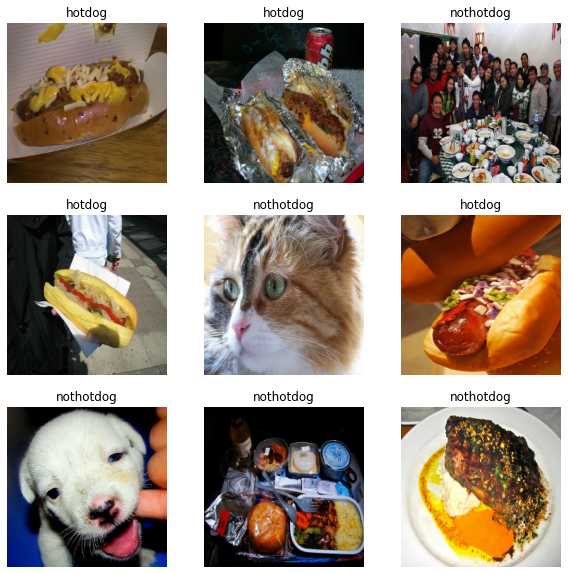

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Using buffered prefetching we can yield data from disk without having I/O become blocking. This can be accomplished by suing the following methods when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

*Source: [Better performance with the](../../guide/data_performance.ipynb)* `tf.data` *API guide*

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. We can apply normalization either before training using something like:

```Python
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Check that the pixel values are now in the range [0,1]
print(np.min(first_image), np.max(first_image)) 
```

Or, we can include it as part of our model definition (we'll take this approach). Similarly, we could've included the resizing of images solely in our model definition. As we want to account for processing images _after_ the model is trained, we will include these two operations in the model definition.

## Prepare the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

![](https://raw.github.com/datasith/ML-Notebooks-TensorFlow/main/img//Image_Classification_AlexNet/alexnet.png)

### Prevent overfitting

Given **AlexNet**'s architecture, which includes 60 million parameters, we expect the model to overfit the data. Similar to the authors of the original model, we include in our model definition:

**Data Augmentation** — label-preserving transformations such as rotations, flips, shearing to make the training data more varied.

**Dropout** — a technique where during each iteration, different weights are prevented (dropped out) from being updated

In [15]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

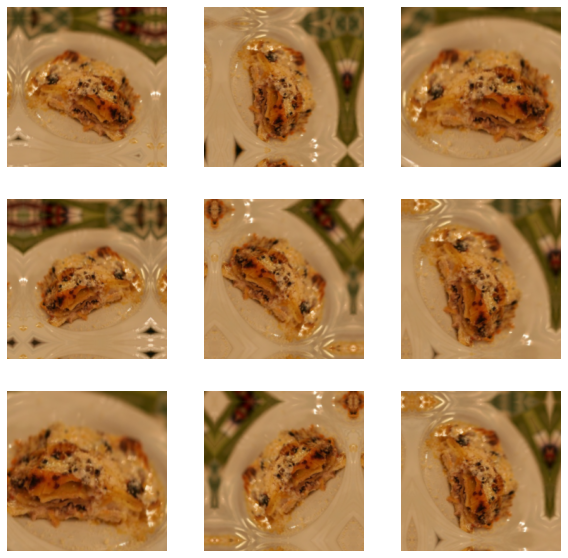

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images, training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

With the **Data Augmentation** layer in place we can proceed to define our version of the **AlexNet** model:

In [17]:
num_classes = len(class_names)

if 'model' in globals():
    del model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, None, 3)),                             
    tf.keras.layers.Resizing(img_height, img_width),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    # Here, we use a larger 11 x 11 window to capture objects. At the same time,
    # we use a stride of 4 to greatly reduce the height and width of the output.
    # Also, the number of output channels is much larger than that in LeNet
    tf.keras.layers.Conv2D(32, #64
                           kernel_size=3, #11
                           strides=1, #4
                           padding='same', #valid
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the
    # number of output channels    
    tf.keras.layers.Conv2D(64, #256
                           kernel_size=3, #5
                           strides=1,
                           padding='same',
                           activation='relu'),   
    tf.keras.layers.MaxPooling2D(pool_size=2, #3
                                 strides=2),
    tf.keras.layers.BatchNormalization(),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of
    # output channels is further increased. Pooling layers are not used to
    # reduce the height and width of input after the first two
    # convolutional layers
    tf.keras.layers.Conv2D(64, #384
                           kernel_size=2, #3
                           strides=1, 
                           padding='same', 
                           activation='relu'),   
    # tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'), #384
    # tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2, #3
                                 strides=2),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), #4096
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(256, activation='relu'), #4096
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Compile and train the model

For a deep learning problem, we will usually define a *loss function* and use an *optimization algorithm* to (try to) minimize the loss. Whereas the loss is computed from the errors between prediction and true data in the training set, the ability of our model (once trained) to accurately predict unseen data (generalize) are different. To accomplish the latter we need to pay attention to overfitting, in addition to using the optimization algorithm to reduce the training error.

In [18]:
learning_rate = 0.0001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

We specify the training configuration (optimizer, loss, metrics) as parameters in the `.compile()` method.

In [19]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 64)      18496     
                                                      

In [20]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.05, 
    patience=5, 
    min_lr=1e-6, 
    mode='min', 
    verbose=1
)

We call `.fit()` so that we train the model with the "batches" present in our training set. The method iterates over the entire dataset for a given number of `epochs`.

In [21]:
epochs=30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,
    callbacks = [es, rlp]
)

Epoch 1/30
107/107 [==============================] - 47s 430ms/step - loss: 0.8184 - accuracy: 0.6117 - val_loss: 1.9786 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 2/30
107/107 [==============================] - 47s 435ms/step - loss: 0.5983 - accuracy: 0.6865 - val_loss: 3.2259 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 3/30
107/107 [==============================] - 47s 442ms/step - loss: 0.5866 - accuracy: 0.6962 - val_loss: 3.4187 - val_accuracy: 0.5318 - lr: 1.0000e-04
Epoch 4/30
107/107 [==============================] - 47s 439ms/step - loss: 0.5710 - accuracy: 0.7024 - val_loss: 1.4556 - val_accuracy: 0.6781 - lr: 1.0000e-04
Epoch 5/30
107/107 [==============================] - 48s 446ms/step - loss: 0.5476 - accuracy: 0.7254 - val_loss: 0.8645 - val_accuracy: 0.6616 - lr: 1.0000e-04
Epoch 6/30
107/107 [==============================] - 47s 441ms/step - loss: 0.5281 - accuracy: 0.7363 - val_loss: 1.1895 - val_accuracy: 0.5590 - lr: 1.0000e-04
Epoch 7/30
107/107 [========

### Model evaluation

Several different metrics are used in Machine Learning to measure the predictive accuracy of a model. The choice of metric depends on the task, and in our case we chose one of the simplest which is "accuracy". This is a measure of the ratio of correct predictions (on data that wasn't used for training) over the total number of predictions.


Using the `.evaluate()` method of the model we built, we can access the results for the entirety of our test dataset:

In [22]:
score = model.evaluate(test_ds, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.7237846255302429
Test accuracy: 0.6324999928474426


As usual, we can visualize the accuracy (and loss) throughout the entire training:

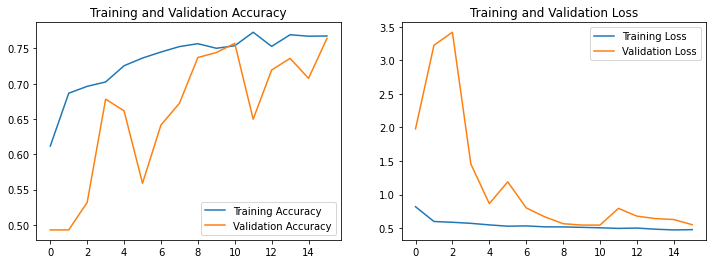

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model saving (and re-loading)

Once we're happy with the performance of our model on testing (unseen) data, we can use the built-in `.save()` method to export our trained model and deploy it in our application.

In [24]:
model.save('model_alexnet.h5')

And, as a sanity check, we can reload it and see that we get what we expect:

In [25]:
new_model = tf.keras.models.load_model('model_alexnet.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 64)      18496     
                                                      

We can use the save-reloaded model to test some predictions on additional data from the (unseen) test set:

0.23312866687774658 hotdog
0.09104517102241516 hotdog
0.094571053981781 hotdog
0.8298299312591553 nothotdog
0.7047052979469299 nothotdog
0.18175452947616577 hotdog


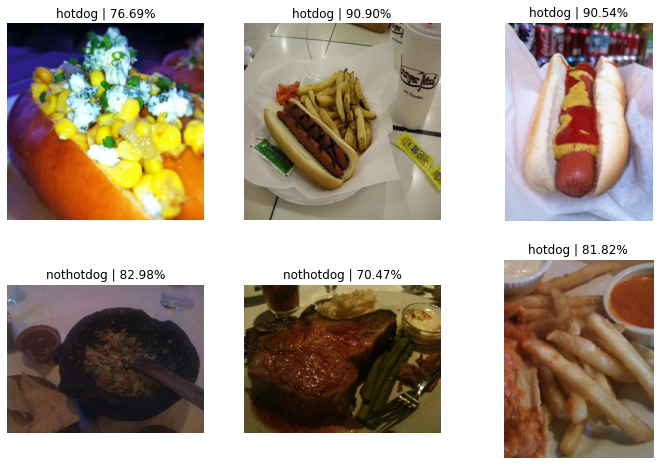

In [50]:
plt.figure(figsize=(12, 8), facecolor='white')
counter = 1
for cls in class_names:
    path_images = path_test_data / Path(f"{cls}/*.jpg")
    files_images = glob.glob(path_images.as_posix(),recursive = True)
    for idx in random.sample(range(0, len(files_images)), 3):
        ax = plt.subplot(number_classes, 3, counter)

        img = cv2.imread(files_images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model.predict(img_array).item()
        cls = class_names[np.rint(prediction).astype(int)]

        print(prediction, cls)

        if prediction <= .5:
            score = 1 - prediction
        else:
            score = prediction

        pred_str = f"{cls} | {score*100:.2f}%"
        plt.title(pred_str)
        plt.axis("off")
        plt.imshow(img)

        counter += 1

And, as a final test, we can search for an image belonging to one of the classes on the internet, and get the model's prediction:

49152/34933 [==========================================] - 0s 0us/step
0.35916054248809814 hotdog
This image most likely belongs to 'hotdog' with a 64.08 percent confidence.


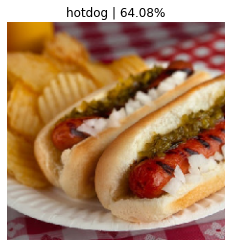

In [49]:
hotdog_url = "https://bigoven-res.cloudinary.com/image/upload/h_320,w_320,c_fill/homemade-hot-dogs-2.jpg"
hotdog_path = tf.keras.utils.get_file('hotdog', origin=hotdog_url)

img = tf.keras.utils.load_img(
    hotdog_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

prediction = model.predict(img_array).item()
cls = class_names[np.rint(prediction).astype(int)]

print(prediction, cls)

if prediction <= .5:
    score = 1 - prediction
else:
    score = prediction

pred_str = f"{cls} | {score*100:.2f}%"
plt.title(pred_str)
plt.axis("off")
plt.imshow(img)

print(f"This image most likely belongs to '{cls}' with a {score*100:.2f} percent confidence.")

## References:

- [TensorFlow: Training and evaluation with the built-in methods](https://www.tensorflow.org/guide/keras/train_and_evaluate)
- [TensorFlow: Basic classification: Classify images of clothing](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb)